In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/testii/virat.jpg
/kaggle/input/facenet-tensorflow/tensorflow2/default/2/fingerprint.pb
/kaggle/input/facenet-tensorflow/tensorflow2/default/2/saved_model.pb
/kaggle/input/facenet-tensorflow/tensorflow2/default/2/keras_metadata.pb
/kaggle/input/facenet-tensorflow/tensorflow2/default/2/variables/variables.index
/kaggle/input/facenet-tensorflow/tensorflow2/default/2/variables/variables.data-00000-of-00001
/kaggle/input/rohit11/rohit.jpg


In [2]:
!pip install tensorflow mtcnn opencv-python matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.0 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install kagglehub


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import kagglehub
path = kagglehub.model_download("faiqueali/facenet-tensorflow/tensorFlow2/default")
print("Path to model files:", path)

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to model files: /kaggle/input/facenet-tensorflow/tensorflow2/default/2


In [5]:
path

'/kaggle/input/facenet-tensorflow/tensorflow2/default/2'

E0000 00:00:1746599892.824314      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230
I0000 00:00:1746599911.308583      10 service.cc:148] XLA service 0x59eddf8c4600 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746599911.308654      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1746599911.308658      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1746599911.308661      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1746599911.308663      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1746599911.308666      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1746599911.308669      10 service.cc:156]   Strea


 Distance between faces: 0.0000


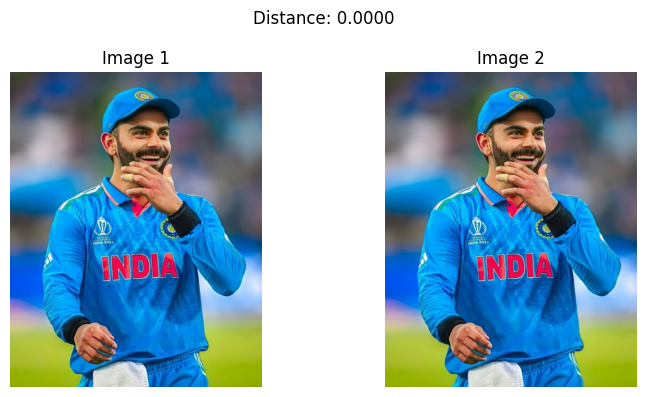

In [6]:
import tensorflow as tf
import numpy as np
import cv2
from mtcnn import MTCNN
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os


detector = MTCNN()


model_dir = path
model = tf.saved_model.load(model_dir)
infer = model.signatures['serving_default']


def prewhiten(x):
    mean = np.mean(x)
    std = np.std(x)
    std_adj = np.maximum(std, 1.0 / np.sqrt(x.size))
    return (x - mean) / std_adj


def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Could not read image: {img_path}")
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = detector.detect_faces(img_rgb)
    
    if not faces:
        raise ValueError("No face detected.")

    x, y, w, h = faces[0]['box']
    face = img_rgb[y:y+h, x:x+w]
    face = cv2.resize(face, (160, 160))
    face = prewhiten(face)
    face = np.expand_dims(face, axis=0)
    return face, img_rgb, faces[0]['box']

# Get embedding from the FaceNet model
def get_face_embedding(img_path):
    face_input, _, _ = preprocess_image(img_path)
    result = infer(tf.convert_to_tensor(face_input, dtype=tf.float32))
    embedding_key = list(result.keys())[0]  # Auto-detect the correct key
    embedding = result[embedding_key].numpy()
    return embedding


def check_faces_similarity(img_path1, img_path2, threshold=0.6):
    try:
        emb1 = get_face_embedding(img_path1)
        emb2 = get_face_embedding(img_path2)

        distance = np.linalg.norm(emb1 - emb2)
        same = distance < threshold

        print(f"\n Distance between faces: {distance:.4f}")
       

        # Show images side-by-side
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        for ax, path, title in zip(axs, [img_path1, img_path2], ["Image 1", "Image 2"]):
            img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
            ax.imshow(img)
            ax.set_title(title)
            ax.axis('off')
        plt.suptitle(f"Distance: {distance:.4f}")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error: {e}")

# Example usage
img_path1 = '/kaggle/input/testii/virat.jpg'
img_path2 = '/kaggle/input/testii/virat.jpg'
check_faces_similarity(img_path1, img_path2)


In [8]:
!pip install lz4



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [9]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


model_dir = path


model = tf.saved_model.load(model_dir)


infer = model.signatures['serving_default']

def preprocess_image(img_path):
    """Load and preprocess the image."""
    img = image.load_img(img_path, target_size=(160, 160))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

def get_face_embedding(img_path):
    """Generate face embedding from an image."""
    img = preprocess_image(img_path)
    # Perform inference using the callable function
    result = infer(tf.convert_to_tensor(img, dtype=tf.float32))
    embedding = result['Bottleneck_BatchNorm'].numpy()  
    return embedding

def check_faces_similarity(img_path1, img_path2, threshold=0.6):
    """Verify if two faces are the same person based on embeddings."""
    embedding1 = get_face_embedding(img_path1)
    embedding2 = get_face_embedding(img_path2)

    # Compute Euclidean distance between embeddings
    distance = np.linalg.norm(embedding1 - embedding2)
    print(f'Distance between faces: {distance}')

# Example usage
img_path1 = '/kaggle/input/testii/virat.jpg'
img_path2 = '/kaggle/input/testii/virat.jpg'

check_faces_similarity(img_path1, img_path2)


Distance between faces: 0.0



 Distance between faces: 0.0000


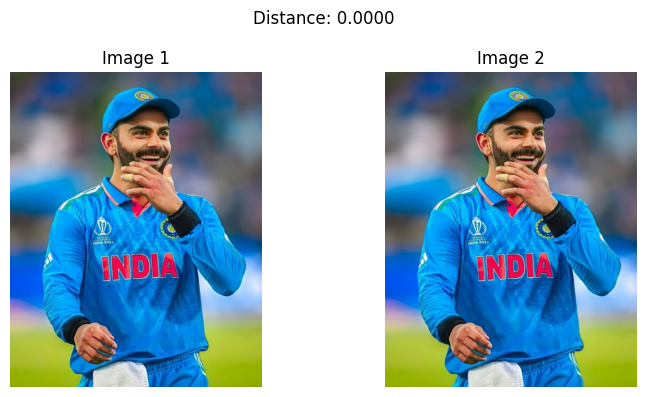

In [10]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os


model_dir = path 


model = tf.saved_model.load(model_dir)
infer = model.signatures['serving_default']

def prewhiten(x):
    """Apply FaceNet's prewhitening normalization."""
    mean = np.mean(x)
    std = np.std(x)
    std_adj = np.maximum(std, 1.0 / np.sqrt(x.size))
    return (x - mean) / std_adj

def preprocess_image(img_path):
    """Load and preprocess the image."""
    img = image.load_img(img_path, target_size=(160, 160))
    img_array = image.img_to_array(img)
    img_array = prewhiten(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def get_face_embedding(img_path):
    """Generate face embedding from an image."""
    img = preprocess_image(img_path)
    result = infer(tf.convert_to_tensor(img, dtype=tf.float32))
    embedding_key = list(result.keys())[0] 
    embedding = result[embedding_key].numpy()
    return embedding

def check_faces_similarity(img_path1, img_path2, threshold=0.6):
    """Verify if two faces are the same person based on embeddings, and display them."""
    embedding1 = get_face_embedding(img_path1)
    embedding2 = get_face_embedding(img_path2)

    distance = np.linalg.norm(embedding1 - embedding2)
    same = distance < threshold

    print(f"\n Distance between faces: {distance:.4f}")
    img1 = mpimg.imread(img_path1)
    img2 = mpimg.imread(img_path2)

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(img1)
    axs[0].axis('off')
    axs[0].set_title("Image 1")

    axs[1].imshow(img2)
    axs[1].axis('off')
    axs[1].set_title("Image 2")

    plt.suptitle(f"Distance: {distance:.4f}")
    plt.tight_layout()
    plt.show()


img_path1 = '/kaggle/input/testii/virat.jpg'  
img_path2 = '/kaggle/input/testii/virat.jpg'  

check_faces_similarity(img_path1, img_path2)



 Distance between faces: 0.0000


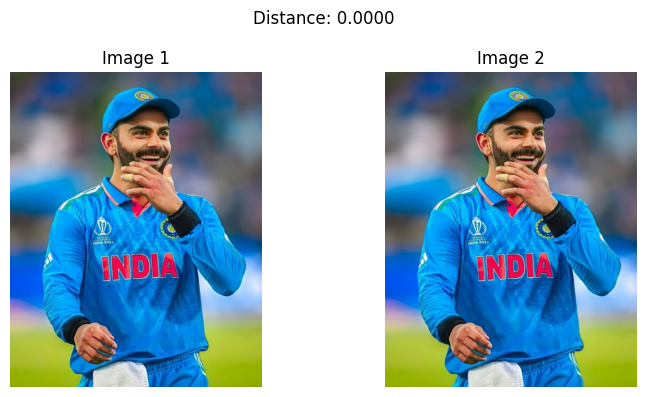

In [11]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from mtcnn import MTCNN
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os


detector = MTCNN()


model_dir = path   
model = tf.saved_model.load(model_dir)
infer = model.signatures['serving_default']

def prewhiten(x):
    """Apply FaceNet's prewhitening normalization."""
    mean = np.mean(x)
    std = np.std(x)
    std_adj = np.maximum(std, 1.0 / np.sqrt(x.size))
    return (x - mean) / std_adj

def detect_and_crop_face(img_path):
    """Detect face and crop using MTCNN."""
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f" Could not read image: {img_path}")
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = detector.detect_faces(img_rgb)

    if not faces:
        raise ValueError(" No face detected.")

    x, y, w, h = faces[0]['box']
    face = img_rgb[y:y+h, x:x+w]
    face = cv2.resize(face, (160, 160))
    return face

def get_face_embedding(img_path):
    """Generate face embedding from an image with MTCNN cropping."""
    face = detect_and_crop_face(img_path)
    face = prewhiten(face)
    face = np.expand_dims(face, axis=0)
    result = infer(tf.convert_to_tensor(face, dtype=tf.float32))
    embedding_key = list(result.keys())[0]
    embedding = result[embedding_key].numpy()
    return embedding

def check_faces_similarity(img_path1, img_path2, threshold=0.6):
    """Compare two face images using MTCNN and FaceNet."""
    embedding1 = get_face_embedding(img_path1)
    embedding2 = get_face_embedding(img_path2)

    distance = np.linalg.norm(embedding1 - embedding2)
    same = distance < threshold

    print(f"\n Distance between faces: {distance:.4f}")
    
    img1 = mpimg.imread(img_path1)
    img2 = mpimg.imread(img_path2)

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(img1)
    axs[0].axis('off')
    axs[0].set_title("Image 1")

    axs[1].imshow(img2)
    axs[1].axis('off')
    axs[1].set_title("Image 2")

    plt.suptitle(f"Distance: {distance:.4f}")
    plt.tight_layout()
    plt.show()


img_path1 = '/kaggle/input/testii/virat.jpg'
img_path2 = '/kaggle/input/testii/virat.jpg'

check_faces_similarity(img_path1, img_path2)


 Distance between faces: 0.0000


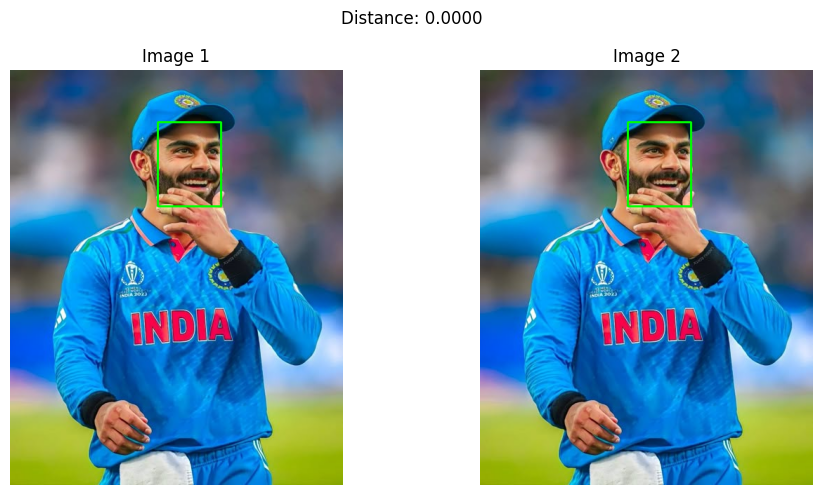

In [12]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from mtcnn import MTCNN
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os


detector = MTCNN()


model_dir = path  
model = tf.saved_model.load(model_dir)
infer = model.signatures['serving_default']


def prewhiten(x):
    mean = np.mean(x)
    std = np.std(x)
    std_adj = np.maximum(std, 1.0 / np.sqrt(x.size))
    return (x - mean) / std_adj

def detect_and_crop_face(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Could not read image: {img_path}")

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = detector.detect_faces(img_rgb)

    if not faces:
        raise ValueError("No face detected.")

    x, y, w, h = faces[0]['box']
    face = img_rgb[y:y+h, x:x+w]
    face = cv2.resize(face, (160, 160))

    # Draw rectangle on original image
    img_annotated = img_rgb.copy()
    cv2.rectangle(img_annotated, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return face, img_annotated


def get_face_embedding(img_path):
    face, _ = detect_and_crop_face(img_path)
    face = prewhiten(face)
    face = np.expand_dims(face, axis=0)
    result = infer(tf.convert_to_tensor(face, dtype=tf.float32))
    embedding_key = list(result.keys())[0]
    embedding = result[embedding_key].numpy()
    return embedding


def check_faces_similarity(img_path1, img_path2, threshold=0.6):
    embedding1 = get_face_embedding(img_path1)
    embedding2 = get_face_embedding(img_path2)

    distance = np.linalg.norm(embedding1 - embedding2)
    same = distance < threshold

    print(f" Distance between faces: {distance:.4f}")
    

    # Show annotated images with boxes
    _, img1_boxed = detect_and_crop_face(img_path1)
    _, img2_boxed = detect_and_crop_face(img_path2)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img1_boxed)
    axs[0].axis('off')
    axs[0].set_title("Image 1")

    axs[1].imshow(img2_boxed)
    axs[1].axis('off')
    axs[1].set_title("Image 2")

    plt.suptitle(f"Distance: {distance:.4f}")
    plt.tight_layout()
    plt.show()

# Example usage
img_path1 = '/kaggle/input/testii/virat.jpg'
img_path2 = '/kaggle/input/testii/virat.jpg'

check_faces_similarity(img_path1, img_path2)


 Distance between faces: 12.5032


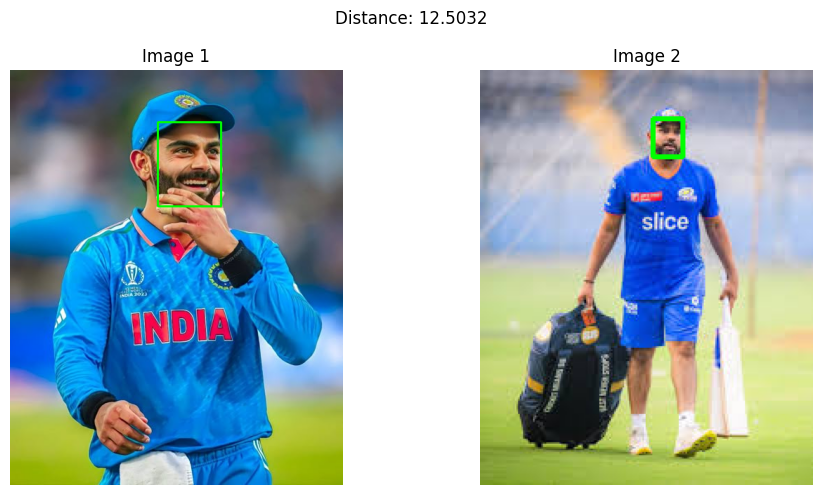

In [13]:
img_path1 = '/kaggle/input/testii/virat.jpg'
img_path2 = '/kaggle/input/rohit11/rohit.jpg'
check_faces_similarity(img_path1, img_path2)